In [53]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
import sys
import math
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="whitegrid")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [44]:
f = 0.1 #Mining rate
m = 1000 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee

'''
Number of public proposal block
proposer_block[0] is mined by honest node, proposer_block[1] is mined by adversarial node
proposer_block[0] is A in the report, proposer_block[1] is B in the report
'''
proposer_blocks = 2 

beta_actual = 0.15
# probability with which an incoming voting block has been mined by adversary

'''
probability of choosing proposal block A and B, respectively, by honest nodes.
'''
prob_selecting_proposer_blocks_by_honest_nodes = [0, 1] 


beta_calc = np.array([ 0.15, 0.2, 0.25, .3, .35, 0.4]) # probability using which V_estimate is calculated


## Prism Latency Simulation

In [45]:
# Number of adverserial blocks in private at time t
def adverserial(t, beta, fv):
    x = np.arange(0,3000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)

#Probability that a vote with depth k will be removed when adversary has Z_t blocks in private
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans

def runExp(m, log_epsilon, fv, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual):
    events = int(20000*log_epsilon)
    time_array_for_list_confirmation = np.zeros_like(beta_calc)
    time_array_for_unique_block_confirmation = np.zeros_like(beta_calc)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    
    
    '''
    Determining whether the mined block at each event is from an honest node or from an adversary
    Each element is associated with an event of mining a block 
    Each element specifies whether the block is mined by adversary or honest node
    '''
    mined_by_adversary_or_honest_node = np.random.choice(['Honest', 'Adversary'], events, p = [1 - beta_actual, beta_actual])
    print(mined_by_adversary_or_honest_node)

    print_once = True
    for j, beta in enumerate(beta_calc):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)

        print('beta')
        print(beta)
        
        # the following variables are used for the computation of \underbar{V}_{n}(r)
        votes_permanence_E_A, votes_permanence_V_A =  np.zeros(m),  np.zeros(m)
        time_for_list_confirmation, time_for_unique_block_confirmation, mean_A, var_A  = 0,0,0,0
        votes_permanence_E_B, votes_permanence_V_B =  np.zeros(m),  np.zeros(m)
        mean_B, var_B  = 0,0        
        list_confirmation_done = False # set it True when list confirmation done        
            
        '''
        The following vector contains proposal block voted by each of the voter chain
        It can be updated everytime a voter block is mined 
        (specifically, in case of tie in length of competing forked chains)
        Initially, no voter block has been mined and so no voting yet, thus, initializing with None
        If proposal_block_selected_by_voter_chain[rChain] = 0, then vote is for A
        If proposal_block_selected_by_voter_chain[rChain] = 1, then vote is for B
        '''
        proposal_block_selected_by_voter_chain = np.asarray([None]*m) 


        '''
        n_A is the number of votes for A in a chain along the voting tree
        n_B is the number of votes for B in a chain along the voting tree
        Initially, no votes cast, so, initialized with 0
        '''
        n_A = np.zeros(m)
        n_B = np.zeros(m)
        h_A = np.zeros(m)
        h_B = np.zeros(m)        
        a_A = np.zeros(m)
        a_B = np.zeros(m)        
        # number of events of flipping
        flip_event_count = 0
        
        
        for i, tDiff in enumerate(exp_random_v):
            # print(i)
            # incrementing time
            # if beta == 0.4:
            #    print(i)
            
            time_for_unique_block_confirmation += tDiff
            
            if list_confirmation_done == False:
                time_for_list_confirmation += tDiff
                
            
            # Selecting the chain to add the voting block (by sortition)
            rChain = chain_random_v[i]
            # indicates whether the vote from a voter chain has flipped or not due to balancing attack
            flipping  = False 
            
            
            
            
            '''
            (1) Determining whether adversary mined the block or honest node mined the block
            (2) Determining where the vote gets added among the two competing forked voter chains
            '''
            if mined_by_adversary_or_honest_node[i] == 'Adversary':                    
                '''
                The adversary would try to balance the total number of votes 
                '''                    
                number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                    
                # Balance the number of votes for the proposer blocks
                if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                    # flipping of votes only possible in case of equal length of forked chain
                    if n_A[rChain] == n_B[rChain]:
                        '''
                        flipping
                        possible only when adversary is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != 1 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            flipping = True
                        proposal_block_selected_by_voter_chain[rChain] = 1
                    n_B[rChain] += 1
                    a_B[rChain] += 1
                elif number_of_votes_for_A_currently < number_of_votes_for_B_currently:
                    # flipping of votes only possible in case of equal length of forked chains
                    if n_A[rChain] == n_B[rChain]:
                        '''
                        flipping
                        possible only when adversary is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != 0 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''
                        if proposal_block_selected_by_voter_chain[rChain] == 1:
                            flipping = True
                        proposal_block_selected_by_voter_chain[rChain] = 0
                    n_A[rChain] += 1
                    a_A[rChain] += 1
                else: 
                    # Do nothing
                    pass
                    
                
            else:
                # If mined by honest node, then we have following cases
                if n_A[rChain] > n_B[rChain]:
                    # Applying longest chain protocol
                    n_A[rChain] += 1
                    h_A[rChain] += 1
                elif n_A[rChain] < n_B[rChain]:
                    # Applying longest chain protocol
                    n_B[rChain] += 1
                    h_B[rChain] += 1
                else:
                    '''
                    The case for n_A[rChain] = n_B[rChain]
                    In globalised view, count the number of votes that A and B have obtained till now 
                    '''
                    number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                    number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                    
                    # follow maximum vote protocol
                    if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                        '''
                        flipping
                        possible only when honest user is changing the existing vote, that is, the existing vote was
                        proposal_block_selected_by_voter_chain[rChain] != 0 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''
                        if proposal_block_selected_by_voter_chain[rChain] == 1:
                            flipping = True                        
                        proposal_block_selected_by_voter_chain[rChain] = 0
                        n_A[rChain] += 1
                        h_A[rChain] += 1
                    elif number_of_votes_for_A_currently < number_of_votes_for_B_currently: 
                        '''
                        flipping
                        possible only when honest user is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != 1 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''                       
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            flipping  = True
                        proposal_block_selected_by_voter_chain[rChain] = 1
                        n_B[rChain] += 1
                        h_B[rChain] += 1
                    else:
                        proposal_block_selected = np.random.choice([0, 1], 1, p = prob_selecting_proposer_blocks_by_honest_nodes)   
                        '''
                        flipping
                        possible only when honest user is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != proposal_vote_selected and 
                        proposal_block_selected_by_voter_chain[rChain] != None -> so that we are not at the begiining of voting at a chain
                        '''  
                        if (proposal_block_selected_by_voter_chain[rChain] != proposal_block_selected) and (proposal_block_selected_by_voter_chain[rChain] != None):
                            flipping  = True
                        
                        proposal_block_selected_by_voter_chain[rChain] = proposal_block_selected
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            n_A[rChain] += 1
                            h_A[rChain] += 1
                        else:
                            n_B[rChain] += 1
                            h_B[rChain] += 1
                            
             
            if (flipping == True):
                flip_event_count += 1
            
            if proposal_block_selected_by_voter_chain[rChain] == 0:
                '''
                Updating underbar_V_A
                '''
                #Solidified probability
                Z_t = adverserial(time_for_unique_block_confirmation, beta, fv*(1-beta_actual))
                p_i = 1 - p_k_t(n_A[rChain], Z_t, beta)                

                # Updating the mean and variance
                mean_A -= votes_permanence_E_A[rChain]
                var_A  -= votes_permanence_V_A[rChain]            
                votes_permanence_E_A[rChain] = p_i  
                votes_permanence_V_A[rChain] = p_i*(1-p_i)            
                mean_A += votes_permanence_E_A[rChain]
                var_A  += votes_permanence_V_A[rChain]    
                
                
                if flipping == True:
                    '''
                    Updating underbar_V_B when there is flipping
                    Votes from rChain voter tree to proposer block B made 0
                    '''
                    mean_B -= votes_permanence_E_B[rChain]
                    var_B  -= votes_permanence_V_B[rChain]
                    votes_permanence_E_B[rChain] = 0
                    votes_permanence_V_B[rChain] = 0
                
            else:
                '''
                Updating underbar_V_B
                '''
                #Solidified probability
                Z_t = adverserial(time_for_unique_block_confirmation, beta, fv*(1-beta_actual))
                p_i = 1 - p_k_t(n_B[rChain], Z_t, beta)                

                # Updating the mean and variance
                mean_B -= votes_permanence_E_B[rChain]
                var_B  -= votes_permanence_V_B[rChain]            
                votes_permanence_E_B[rChain] = p_i  
                votes_permanence_V_B[rChain] = p_i*(1-p_i)            
                mean_B += votes_permanence_E_B[rChain]
                var_B  += votes_permanence_V_B[rChain]  
                
                if flipping == True:
                    '''
                    Updating underbar_V_A when there is flipping
                    Votes from rChain voter tree to proposer block A made 0
                    '''
                    mean_A -= votes_permanence_E_A[rChain]
                    var_A  -= votes_permanence_V_A[rChain]
                    votes_permanence_E_A[rChain] = 0
                    votes_permanence_V_A[rChain] = 0
                
            
            # print('new round')   
            
            

            underbar_V_A = max(mean_A,0) 
            underbar_V_A = max(mean_A - np.sqrt(2*var_A*log_epsilon),0) 
            
            
            underbar_V_B = max(mean_B,0) 
            underbar_V_B = max(mean_B - np.sqrt(2*var_B*log_epsilon),0)    
            
            
            overbar_V_private = m - underbar_V_A - underbar_V_B  
            

            
            # List confirmation policy
            if underbar_V_A+ underbar_V_B > overbar_V_private and print_once:
                print_once = False
                Z_t = adverserial(time_for_unique_block_confirmation, beta, fv*(1-beta_actual))
                print("500 votes!")
                print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
                print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
                print("overbar_V_private: {0:8.2f}".format(overbar_V_private))
                print("U_current: {0:8.2f}".format(U_current))
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("overbar_V_A: {0:8.2f}".format(overbar_V_A))
                print("overbar_V_B: {0:8.2f}".format(overbar_V_B))
                print("time_for_unique_block_confirmation", time_for_unique_block_confirmation,
                      fv*time_for_unique_block_confirmation,
                      fv*time_for_unique_block_confirmation*beta/(1-beta))
                
            if list_confirmation_done == False:
                if max(underbar_V_A, underbar_V_B) > overbar_V_private:
                    print('list_confirmed')
                    list_confirmation_done = True
                    
                    print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
                    print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
                    print("overbar_V_private: {0:8.2f}".format(overbar_V_private))
                    print("U_current: {0:8.2f}".format(U_current))
                    print("V_A_current: {0:8.2f}".format(V_A_current))
                    print("V_B_current: {0:8.2f}".format(V_B_current))
                    print("overbar_V_A: {0:8.2f}".format(overbar_V_A))
                    print("overbar_V_B: {0:8.2f}".format(overbar_V_B))
                    

                    m_A = 0
                    m_B = 0
                    v_A = 0
                    v_B = 0
                    temp = 0
                    for chain in range(m):
                        Z_t = adverserial(time_for_unique_block_confirmation, beta, fv*(1-beta_actual))
#                         if proposal_block_selected_by_voter_chain[chain] != (n_A[chain] < n_B[chain]):
#                             print("chain", chain, n_A[chain], n_B[chain] )
                        if proposal_block_selected_by_voter_chain[chain] == 0:
                            p_i = 1 - p_k_t(n_A[chain], Z_t, beta)
                            m_A += p_i 
                            v_A += p_i*(1-p_i)
                            temp += 1
                        else:
                            p_i = 1 - p_k_t(n_B[chain], Z_t, beta)
                            v_B += p_i*(1-p_i)
                            m_B += p_i 
                    print ("Hey",underbar_V_A, m_A - np.sqrt(2*v_A*log_epsilon), temp)
                    print ("Hey",underbar_V_B, m_B - np.sqrt(2*v_B*log_epsilon), time_for_unique_block_confirmation)
                    time_array_for_list_confirmation[j] = time_for_list_confirmation
                    
            
            # counting number of voter chains that haven't cast vote for any proposal block
            U_current = np.count_nonzero(proposal_block_selected_by_voter_chain == None)
            # counting number of voter chains that currently casts vote for proposal block A
            V_A_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 0) 
            # counting number of voter chains that currently casts vote for proposal block B
            V_B_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)             
            
            
            '''
            Updating overbar_V_A
            '''
            overbar_V_A = V_A_current + (V_B_current - max(underbar_V_B , 0)) + U_current
            
 
            '''
            Updating overbar_V_B
            '''
            overbar_V_B = V_B_current + (V_A_current - max(underbar_V_A , 0)) + U_current
            
 
            '''
            if beta == 0.4:
                print('new event') 
                print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
                print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
                print("overbar_V_private: {0:8.2f}".format(overbar_V_private))
                print("U_current: {0:8.2f}".format(U_current))
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("overbar_V_A: {0:8.2f}".format(overbar_V_A))
                print("overbar_V_B: {0:8.2f}".format(overbar_V_B))
            '''
    

            # Unique block confirmation policy
            if (underbar_V_A > overbar_V_B) or (overbar_V_A < underbar_V_B):
                time_array_for_unique_block_confirmation[j] = time_for_unique_block_confirmation
                time_array_for_list_confirmation[j] = time_for_list_confirmation
                #print('Is the list is confirmed?')
                #print(list_confirmation_done)
                if list_confirmation_done == False:
                    sys.exit()
                print('List confirmation at: {0:8.2f}'.format(time_for_list_confirmation))
                print('Unique Block confirmation at: {0:8.2f}'.format(time_for_unique_block_confirmation))
                
                print('Number of flippings: {0:8.2f}'.format(flip_event_count))
                print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
                print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
                print("overbar_V_private: {0:8.2f}".format(overbar_V_private))
                print("U_current: {0:8.2f}".format(U_current))
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("overbar_V_A: {0:8.2f}".format(overbar_V_A))
                print("overbar_V_B: {0:8.2f}".format(overbar_V_B))
                break
            

    print('time_array_for_list_confirmation')
    print(time_array_for_list_confirmation)
    print('time_array_for_unique_block_confirmation')
    print(time_array_for_unique_block_confirmation)
    return time_array_for_list_confirmation, time_array_for_unique_block_confirmation


prism_ans_list_confirmation = np.zeros_like(beta_calc)
prism_ans_unique_block_confirmation = np.zeros_like(beta_calc)
prism_ans_list_confirmation_square = np.zeros_like(beta_calc)
prism_ans_unique_block_confirmation_square = np.zeros_like(beta_calc)
no_exp = 5

for i in range(no_exp):
    #T2: Time taken for a proposer block to get confirmed
    temp1, temp2 = runExp(m, log_epsilon, f, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual)
    #T1: Time taken for a unique proposer block to refer the tx_block
    temp1 += np.power(np.e, 1*f)/f
    temp2 += np.power(np.e, 1*f)/f
    prism_ans_list_confirmation += temp1
    prism_ans_list_confirmation_square += temp1*temp1
    prism_ans_unique_block_confirmation += temp2
    prism_ans_unique_block_confirmation_square += temp2*temp2
    
prism_ans_list_confirmation /= no_exp
prism_ans_unique_block_confirmation /= no_exp
prism_ans_list_confirmation_square /= no_exp
prism_ans_unique_block_confirmation_square /= no_exp

prism_ans_list_confirmation_std = np.sqrt(prism_ans_list_confirmation_square - 
                                          prism_ans_list_confirmation*prism_ans_list_confirmation) + np.sqrt(np.power(np.e, 1*f)/f)
            
prism_ans_unique_block_confirmation_std = np.sqrt(prism_ans_unique_block_confirmation_square - 
                                          prism_ans_unique_block_confirmation*prism_ans_unique_block_confirmation) + np.sqrt(np.power(np.e, 1*f)/f)

# prism_ans_list_confirmation_lb = prism_ans_list_confirmation-prism_ans_list_confirmation_std
# prism_ans_list_confirmation_ub = prism_ans_list_confirmation+prism_ans_list_confirmation_std

# prism_ans_unique_block_confirmation_lb = prism_ans_list_confirmation-prism_ans_unique_block_confirmation_std
# prism_ans_unique_block_confirmation_ub = prism_ans_list_confirmation+prism_ans_unique_block_confirmation_std




['Adversary' 'Honest' 'Honest' ... 'Honest' 'Honest' 'Honest']
beta
0.15
500 votes!
underbar_V_A:    68.42
underbar_V_B:   431.89
overbar_V_private:   499.69
U_current:   298.00
V_A_current:   108.00
V_B_current:   594.00
overbar_V_A:   568.70
overbar_V_B:   931.58
time_for_unique_block_confirmation 13.967436808367427 1.3967436808367428 0.2464841789711899
list_confirmed
underbar_V_A:    74.28
underbar_V_B:   462.87
overbar_V_private:   462.85
U_current:   257.00
V_A_current:   116.00
V_B_current:   627.00
overbar_V_A:   537.18
overbar_V_B:   925.72
Hey 74.27779751743246 66.89683563426206 116
Hey 462.87258015454 425.8836371508749 15.812703595107003
List confirmation at:    15.81
Unique Block confirmation at:    18.24
Number of flippings:     2.00
underbar_V_A:    83.13
underbar_V_B:   500.07
overbar_V_private:   416.80
U_current:   210.00
V_A_current:   125.00
V_B_current:   665.00
overbar_V_A:   499.93
overbar_V_B:   916.87
beta
0.2
list_confirmed
underbar_V_A:    73.79
underbar_V_B:  

500 votes!
underbar_V_A:    61.91
underbar_V_B:   438.53
overbar_V_private:   499.56
U_current:   305.00
V_A_current:   101.00
V_B_current:   594.00
overbar_V_A:   562.07
overbar_V_B:   938.09
time_for_unique_block_confirmation 13.171466015100908 1.3171466015100908 0.23243763556060426
list_confirmed
underbar_V_A:    65.86
underbar_V_B:   467.10
overbar_V_private:   467.04
U_current:   269.00
V_A_current:   105.00
V_B_current:   626.00
overbar_V_A:   532.98
overbar_V_B:   934.14
Hey 65.8589568378624 58.00540750733575 105
Hey 467.0996804255116 430.3048448735796 14.98048054016658
List confirmation at:    14.98
Unique Block confirmation at:    17.16
Number of flippings:     4.00
underbar_V_A:    73.62
underbar_V_B:   500.08
overbar_V_private:   426.31
U_current:   222.00
V_A_current:   113.00
V_B_current:   665.00
overbar_V_A:   499.92
overbar_V_B:   926.38
beta
0.2
list_confirmed
underbar_V_A:    66.13
underbar_V_B:   467.06
overbar_V_private:   466.81
U_current:   196.00
V_A_current:   1

500 votes!
underbar_V_A:    74.23
underbar_V_B:   426.04
overbar_V_private:   499.73
U_current:   306.00
V_A_current:   116.00
V_B_current:   578.00
overbar_V_A:   574.53
overbar_V_B:   925.77
time_for_unique_block_confirmation 14.818669606407147 1.4818669606407147 0.26150593423071433
list_confirmed
underbar_V_A:    80.89
underbar_V_B:   459.94
overbar_V_private:   459.17
U_current:   259.00
V_A_current:   121.00
V_B_current:   620.00
overbar_V_A:   540.62
overbar_V_B:   919.11
Hey 80.88803301709791 72.08306703569095 121
Hey 459.93900934954496 420.81536143643075 17.091632928208732
List confirmation at:    17.09
Unique Block confirmation at:    19.73
Number of flippings:     6.00
underbar_V_A:    91.19
underbar_V_B:   500.29
overbar_V_private:   408.51
U_current:   201.00
V_A_current:   129.00
V_B_current:   670.00
overbar_V_A:   499.71
overbar_V_B:   908.81
beta
0.2
list_confirmed
underbar_V_A:    84.05
underbar_V_B:   458.11
overbar_V_private:   457.84
U_current:   180.00
V_A_current:

## Bitcoin Latency calculation

In [49]:
exponent = 0.8*(1-2*beta_calc)/(1-beta_calc)*np.log((1-beta_calc)/beta_calc)
bitcoin_ans= (log_epsilon)/(exponent*f)

In [50]:
bitcoin_ans

array([ 175.00936462,  240.44917348,  341.33970999,  516.34734425,
        875.01188828, 1849.72759678])

## Plot

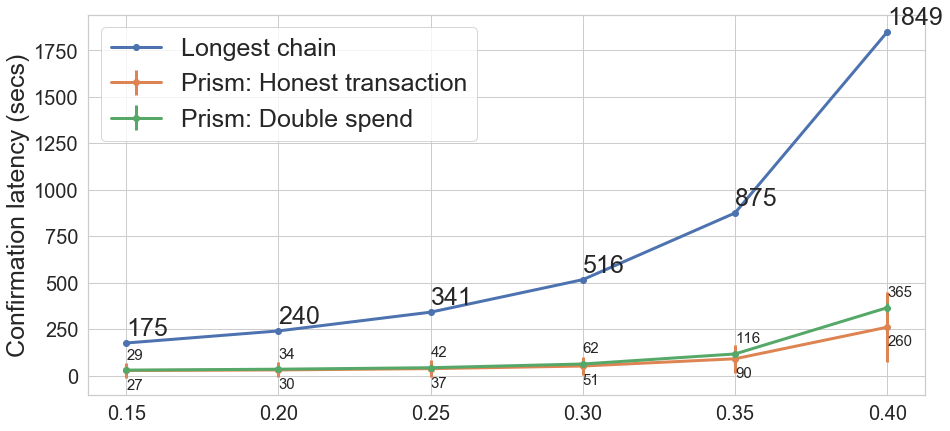

In [54]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans_list_confirmation = prism_ans_list_confirmation.astype(int)
prism_ans_unique_block_confirmation = prism_ans_unique_block_confirmation.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.errorbar(beta_calc, prism_ans_list_confirmation, yerr = 10*prism_ans_list_confirmation_std,
             fmt='-o',lw=3, label="Prism: Honest transaction")
plt.errorbar(beta_calc, prism_ans_unique_block_confirmation, yerr = prism_ans_unique_block_confirmation_std,
             fmt='-o',lw=3, label="Prism: Double spend")

for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans_list_confirmation[i],xy=(beta_calc[i],prism_ans_list_confirmation[i]-100), size=15)
    ax.annotate(prism_ans_unique_block_confirmation[i],xy=(beta_calc[i],prism_ans_unique_block_confirmation[i]+60), size=15)


plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.title("Time to confirm for epsilon = $e$^("+str(-log_epsilon)+") gaurantee with active_beta="+str(beta_actual), size=25)
plt.legend(prop={'size': 25})
plt.show()

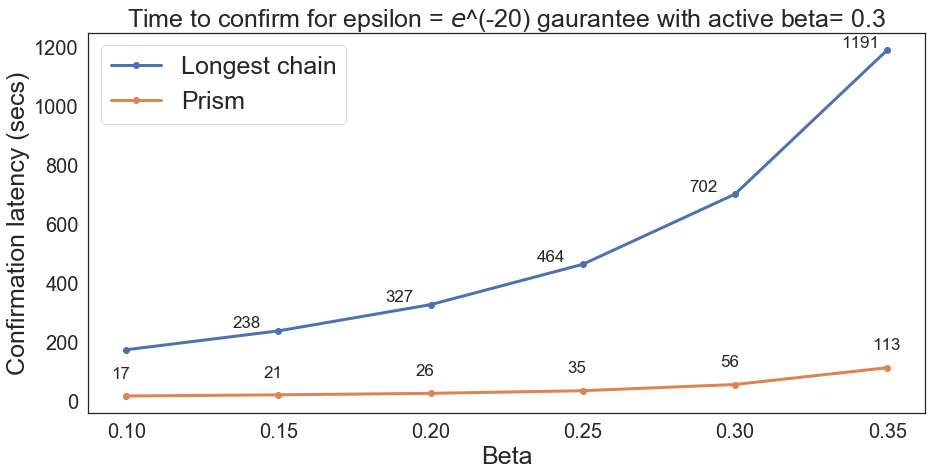

In [13]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans_list_confirmation = prism_ans_list_confirmation.astype(int)
prism_ans_unique_block_confirmation = prism_ans_unique_block_confirmation.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_calc, prism_ans_list_confirmation, '-o',lw=3, label="Prism")
plt.plot(beta_calc, prism_ans_list_confirmation_lb, '-o',lw=3)
plt.plot(beta_calc, prism_ans_list_confirmation_ub, '-o',lw=3)

for i in range(bitcoin_ans.shape[0]):
    
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i]-0.015,bitcoin_ans[i]+10), size=17)
    ax.annotate(prism_ans_list_confirmation[i],xy=(beta_calc[i]-0.005,prism_ans_list_confirmation[i]+60), size=17)


plt.ylabel("Confirmation latency (secs)", size=25)
plt.xlabel("Beta", size=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm for epsilon = $e$^("+str(-log_epsilon)+") gaurantee with active beta= "+str(beta_actual), size=25)
plt.legend(prop={'size': 25})
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans_list_confirmation = prism_ans_list_confirmation.astype(int)
prism_ans_unique_block_confirmation = prism_ans_unique_block_confirmation.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_calc, prism_ans_unique_block_confirmation, '-o',lw=3, label="Prism")

for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i]-0.015,bitcoin_ans[i]+10), size=17)
    ax.annotate(prism_ans_unique_block_confirmation[i],xy=(beta_calc[i],prism_ans_unique_block_confirmation[i]+20), size=17)


plt.ylabel("Confirmation latency (secs)", size=25)
plt.xlabel("Beta", size=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm for epsilon = $e$^("+str(-log_epsilon)+") gaurantee with active beta= "+str(beta_actual), size=25)
plt.legend(prop={'size': 25})
plt.show()

In [4]:
a = np.array([1,2])
a*a

array([1, 4])